In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

from sklearn.decomposition import PCA

from maskrcnn.preprocess.sample_aoi import load_df
from maskrcnn.postprocess.validate import transform_coord, plot_scatter

In [2]:
# input path
SAT_IN_DIR = 'data/Nightlight/VIIRS_DNB_MX_2018.tif'
FULL_CEN_IN_DIR = 'data/CPV/Raw/ITER2010/ITER_NALDBF10.csv'
CEN_IN_DIR = 'data/Experiment0/census.csv'
# output path
OUT_DIR = 'data/Experiment0/Output/'

In [3]:
# renamed columns in census, translate to English
CEN_COLS = {
    'POBTOT': 'cen_pop',
    'VIVTOT': 'cen_house',
    'TVIVHAB': 'cen_inhab',
    'asset_score1': 'cen_asset_score1',
    'asset_score2': 'cen_asset_score2',
    'asset_score3': 'cen_asset_score3',
    'VPH_SNBIEN': 'cen_nodurable',
    'VPH_1CUART': 'cen_1room',
    'VPH_3YMASC': 'cen_3plusroom',
    'VPH_REFRI': 'cen_refri',
    'VPH_AUTOM': 'cen_autom',
    'VPH_C_ELEC': 'cen_elec',
    'VPH_PISODT': 'cen_floor',
    'VPH_AGUADV': 'cen_water',
    'VPH_EXCSA': 'cen_toilet',
    'VPH_DRENAJ': 'cen_drainage',
    'VPH_INTER': 'cen_internet'
}

In [4]:
dataset = rasterio.open(SAT_IN_DIR)
band = dataset.read(1)

In [5]:
df = load_df(FULL_CEN_IN_DIR, drop=False)

In [6]:
df = df.sample(n=200, random_state=1, weights='POBTOT')

In [7]:
idx = np.round(transform_coord(
    transform=dataset.transform,
    to='colrow',
    xy=df.loc[:, ['lon', 'lat']].values)).astype(np.int)

df['nightlight'] = [band[i[1], i[0]] for i in idx]

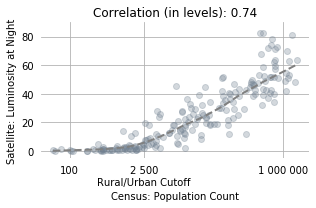

In [8]:
plot_scatter(
    col_x_key='POBTOT',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xticks=[np.log10(1e2 + 1), np.log10(2.5e3 + 1), np.log10(1e6 + 1)],
    xticklabels=['100', '2 500\nRural/Urban Cutoff', '1 000 000'],
    col_y_key='nightlight',
    col_y_label='Satellite: Luminosity at Night',
    ylim=(-5, 90),
    alpha=0.3, line=True, df=df, out_dir=OUT_DIR, show=True)

In [9]:
# read census data
df = pd.read_csv(CEN_IN_DIR)
# compute asset score
vph_cols = [col for col in df.columns if col.startswith('VPH')]
m = PCA(n_components=3)
df = pd.concat([
    df.reset_index(drop=True),
    pd.DataFrame(m.fit_transform(df.loc[:, vph_cols].values),
                 columns=['asset_score1', 'asset_score2', 'asset_score3'])],
    axis=1)
df['asset_score1'] = - df['asset_score1']
# rename and select columns
df = (df.loc[:, ['ent', 'mun', 'loc', 'sample', 'lon', 'lat'] + list(CEN_COLS.keys())]
        .rename(columns=CEN_COLS))

In [10]:
idx = np.round(transform_coord(
    transform=dataset.transform,
    to='colrow',
    xy=df.loc[:, ['lon', 'lat']].values)).astype(np.int)

df['nightlight'] = [band[i[1], i[0]] for i in idx]

In [11]:
# drop outliers
df = df.loc[df['nightlight'] <= df['nightlight'].quantile(q=0.97), :]

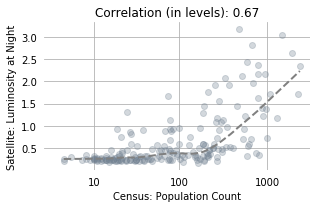

In [12]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(3), np.log10(3000)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='nightlight',
    col_y_label='Satellite: Luminosity at Night',
    alpha=0.3, line=True, df=df.loc[df['cen_pop'] <= 2500, :],
    out_dir=OUT_DIR, show=True)

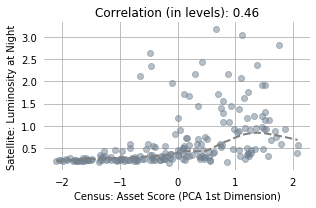

In [13]:
plot_scatter(
    col_x_key='cen_asset_score1',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    col_y_key='nightlight',
    col_y_label='Satellite: Luminosity at Night',
    line=True, df=df, out_dir=OUT_DIR, show=True)